In [2]:
from src.datasets import NoisySpeechDataset
from src.utils import checkpoint
from src.utils.notebook import Sampler, visualize_audio 

In [3]:
import torch

from src.utils import augment


class AugmentedSpeechDataset(NoisySpeechDataset):
    def __getitem__(self, idx):
        """
        Get item by integer index,
        """
        clean = self.clean_data[idx]
        noisy = augment.mask_high_freq(clean, mask_freq=3500)
#         noisy = augment.add_noise(noisy, noise_stdev=5e-5)
        # MSE on augmented data works OK on this
        #noisy = augment.mask_low_freq(clean, mask_freq=1000)
        return torch.tensor(noisy), torch.tensor(clean)



In [4]:
dataset = AugmentedSpeechDataset(train=False, quiet=True)

In [49]:
# Noisy speech dataset
# CHECKPOINT = 'wave-u-net-new-baseline-1573206080.full.ckpt'  # GAN + FL baseline 24 epochs
# CHECKPOINT = 'wave-u-net-two-time-update-rule-1573252521.full.ckpt' # TTUR
# CHECKPOINT = 'wave-u-net-mse-gan-feature-losses-1573224098.full.ckpt' # MSE + GAN + FL 30 epochs
# CHECKPOINT = 'wave-u-net-mse-onlyy-1573200273.full.ckpt' # MSE loss only, 30 epochs
# CHECKPOINT = 'wave-u-net-feature-loss-only-1573203595.full.ckpt' # FL only, 18 epochs

# Augmented data
# CHECKPOINT = 'wave-u-net-mse-on-augmented-data-1573230800.full.ckpt' # MSE on augmented, 30 epochs

# Phone filter training
# CHECKPOINT = 'wave-u-net-wave-u-net-mse-1573299173.full.ckpt'  # MSE 30 epochs
CHECKPOINT = 'wave-u-net-wave-u-net-gan-1573315740.full.ckpt' # FL + GAN 30 epochs

In [50]:
net = checkpoint.load(CHECKPOINT, use_cuda=False)
net = net.eval()
sampler = Sampler(net, dataset)

In [51]:
URL = 'http://hwcdn.libsyn.com/p/6/2/4/624d98a205e61696/Episode6.mp3?c_id=16277365&cs_id=16277365&expiration=1573280793&hwt=d38322eec81b7584389a6b9b6a92159a'
START = 18 * 2**16
WIDTH = 2**16
noisy_arr, pred_clean, pred_noise = sampler.get_results_from_mp3_url(URL, start=START, width=WIDTH)
# noisy_arr, clean_arr, pred_clean, pred_noise, true_noise = sampler.get_results(50)

Predicted clean signal


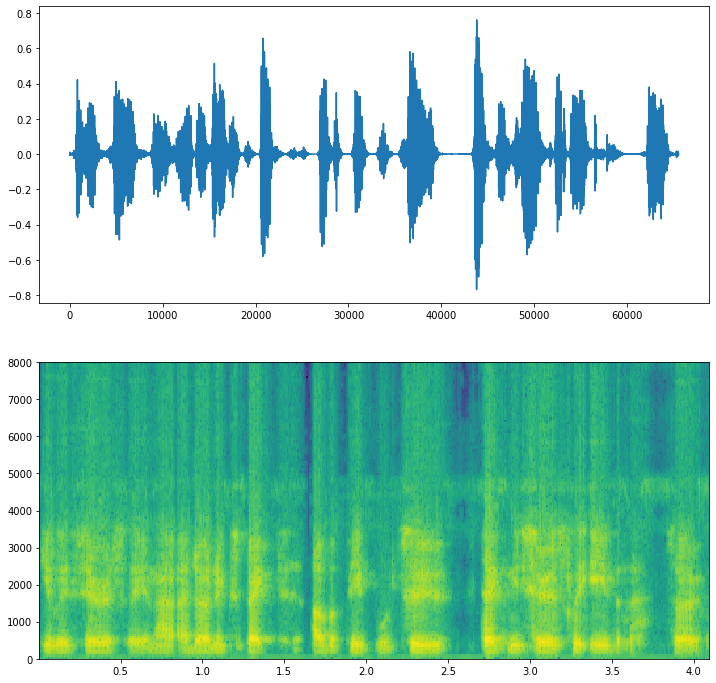

In [52]:
visualize_audio(pred_clean, 'Predicted clean signal')

In [53]:
#visualize_audio(clean_arr, 'Clean signal')

Noisy signal


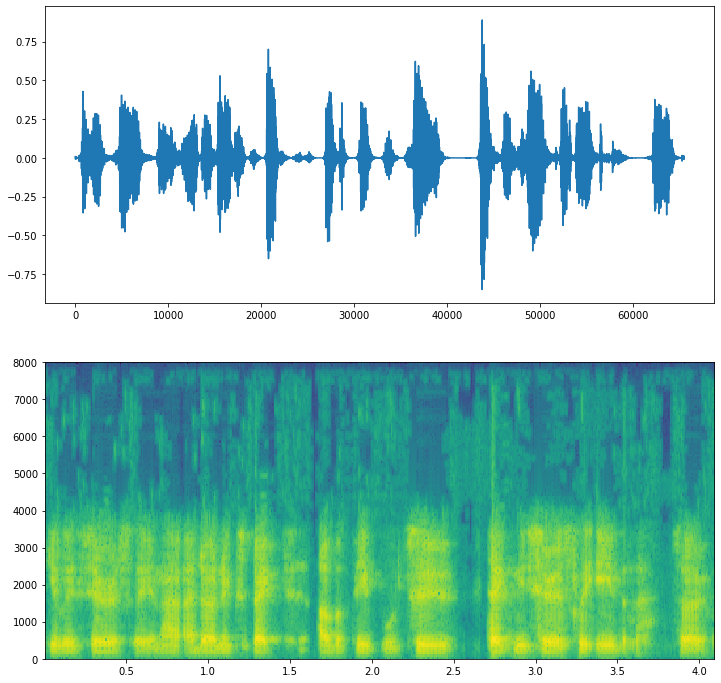

In [54]:
visualize_audio(noisy_arr, 'Noisy signal')

Predicted noise


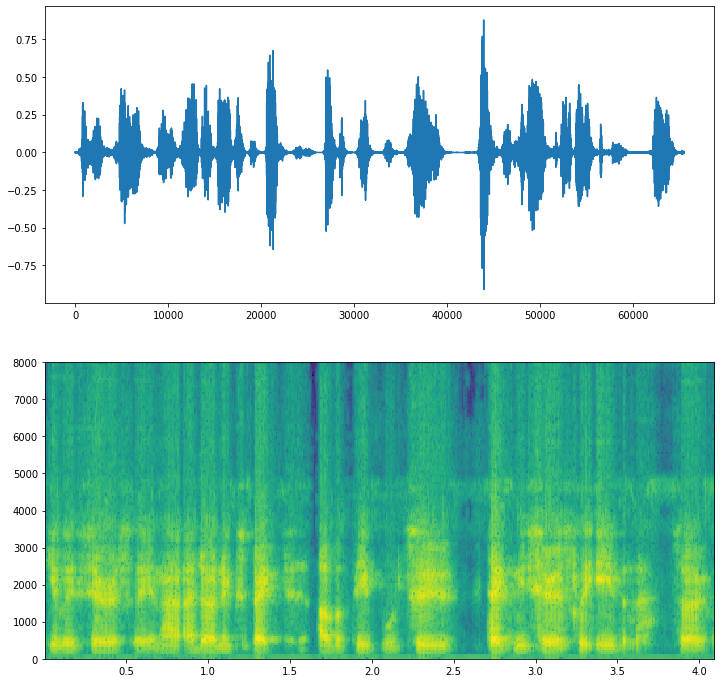

In [55]:
visualize_audio(pred_noise, 'Predicted noise')

In [118]:
# visualize_audio(true_noise, 'True noise signal')